In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import os

# Adding library directory to python search path
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class setup:
    z_err = 0.01   # mm
    p_err = 10     # mm water height
    l = 10         # cm
    wmm2Pa = 9.806
    wave_l = 650 # nano meters
    T = 273 + 22
    P = 103000
    T_0 = 273
    P_0 = 100000
    k_b = 1.38e-16
    n_0 = 1.0002
    n_co2_0 = 1.00045

In [3]:
data = mipt.read_excel('data/4_2_2.xlsx', usecols=['A', 'B', 'C', 'D'], header=(0)).dropna(how='all')
data

,z_m,m,p,z
0,16.32,0,100.0,17.35
1,16.37,1,0.0,17.34
2,16.42,2,-100.0,17.32
3,16.47,3,-200.0,17.29
4,16.52,4,-300.0,17.27
5,16.56,5,-400.0,17.25
6,16.61,6,-500.0,17.23
7,16.66,7,200.0,17.37
8,16.71,8,300.0,17.38
9,16.76,9,350.0,17.40


In [4]:
xsl = {
    "z_m" : "z_m",
    "m" : "m",
    "p" : "p",
    "z" : "z"
}

data = mipt.map_excel(data, xsl)
data

NameError: name 'mipt' is not defined

In [3]:
z_m = data['z_m'].dropna()
m = data['m'].dropna()
mipt.plot(m, z_m, yerr=setup.z_err)

mnk_data = mipt.mnk(m, z_m)
k_cal = mnk_data.get_data()["a"][0]
k_cal_err = mnk_data.get_data()["da"][0]

print(k_cal, k_cal_err)
plt.ylabel(r"$z_m$, мм")
plt.xlabel(r"$m$")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.axvline(x = 0, ymin = -1, ymax = 100, color = 'black', linestyle = '--', linewidth = 0.5)


plt.savefig('gen/calibr.png')
plt.show()

NameError: name 'data' is not defined

2.0142809659099373e-05 3.3256510493670017e-07


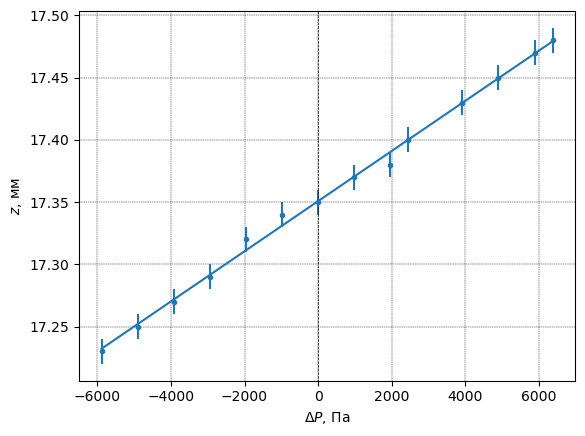

In [6]:
dp = (data["p"].dropna() - data["p"][0]) * setup.wmm2Pa
z = data["z"].dropna()

mipt.plot(dp, z, yerr=setup.z_err)#, xerr=setup.p_err * setup.wmm2Pa)

mnk_data = mipt.mnk(dp, z)
k_dp = mnk_data.get_data()["a"][0]
k_dp_err = mnk_data.get_data()["da"][0]

print(k_dp, k_dp_err)
plt.ylabel(r"$z$, мм")
plt.xlabel(r"$\Delta P$, Па")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.axvline(x = 0, ymin = -1, ymax = 100, color = 'black', linestyle = '--', linewidth = 0.5)


plt.savefig('gen/z_dp.png')
plt.show()

$$\delta n = m \frac{\lambda}{l} = \frac{\Delta z}{k_{cal}} \cdot \frac{\lambda}{l}$$

$$1/\alpha = \frac{2 \pi}{k_b \delta nT} \Delta P = \frac{2 \pi k l}{k_b T \Delta z \lambda} \Delta P = \frac{2 \pi k_{cal} l}{k_b T k_{dp} \lambda}$$

In [7]:
alpha = 1/(2 * np.pi * k_cal * setup.l * 0.01 / (setup.k_b * setup.T * k_dp * setup.wave_l * 10**(-9)))

alpha

1.9357411756626483e-23

In [8]:
alpha_err = alpha*np.sqrt((k_cal_err/k_cal)**2 + (k_dp_err/k_dp)**2 + (1/setup.T)**2)
print(alpha_err, (alpha_err/alpha) * 100)

4.583971860810443e-25 2.368070648309294


$$n = 1 + 2*\pi \alpha * \frac{P}{k_b T}$$

In [9]:
n = 1 + 2* np.pi * alpha * setup.P / (setup.k_b * setup.T)
n_err = (n-1)*np.sqrt((alpha_err/alpha)**2 + (1000/setup.P)**2 + (1/setup.T)**2)
print(n, n_err, n_err/(n-1) * 100)

1.0003077253532013 7.944598558602653e-06 2.581717260522462


$$n_0 = \frac{T P_0}{T_0 P}(n - 1) + 1$$

In [10]:
n_0 = 1 + setup.T * setup.P_0 * (n - 1) / (setup.T_0 * setup.P)
n_0_err = (n_0-1)*np.sqrt((n_err/(n-1))**2 + + (1000/setup.P)**2 + (1/setup.T)**2)
print(n_0, n_0_err, (n_0_err/(n_0-1))*100)

1.0003228385760319 8.971642456801438e-06 2.778987123247463


In [11]:
(1 - setup.n_0/n_0)*100

0.01227989317996725

$$\vec{p} = 3V \cdot \vec{E} = \alpha \vec{E}$$


$$\alpha = 3V = 4\pi r^3$$

$$r = (\alpha / 4\pi)^{1/3}$$

In [12]:
r = (alpha / (4 * np.pi)) ** (1/3)
r

1.1549037939559772e-08

$$n = n_{air} + \Delta / l$$

$$\delta n = \frac{\Delta z}{k_{cal}} \cdot \frac{\lambda}{l} = n_{CO_2} - n_{air}$$

In [13]:
dz = 18.32 - 16.35
dn = dz * setup.wave_l * 10**(-9) / (k_cal * setup.l * 10**(-2))
dn_err = dn*np.sqrt((0.02 / dz)**2 + (k_cal_err/k_cal)**2)
n_co2 = dn + n
n_co2_err = np.sqrt(dn_err**2 + n_err**2)
print(n_co2, n_co2_err, n_co2_err/(n_co2-1) * 100)

1.0005999199840738 9.774447640398571e-06 1.6292918888989232


In [14]:
n_co2_0 = 1 + setup.T * setup.P_0 * (n_co2 - 1) / (setup.T_0 * setup.P)
n_co2_0_err = (n_co2_0-1)*np.sqrt((n_co2_err/(n_co2-1))**2 + (1000/setup.P)**2 + (1/setup.T)**2)
print(n_co2_0, n_co2_0_err, n_co2_0_err/(n_co2_0-1) *100)

1.0006293836740345 1.2126212073616332e-05 1.926680429424513


In [15]:
(1 - setup.n_co2_0/n_co2_0) * 100 

0.0179270843892132